In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [3]:
using_colab = False

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [7]:
image = cv2.imread('images\selfie2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

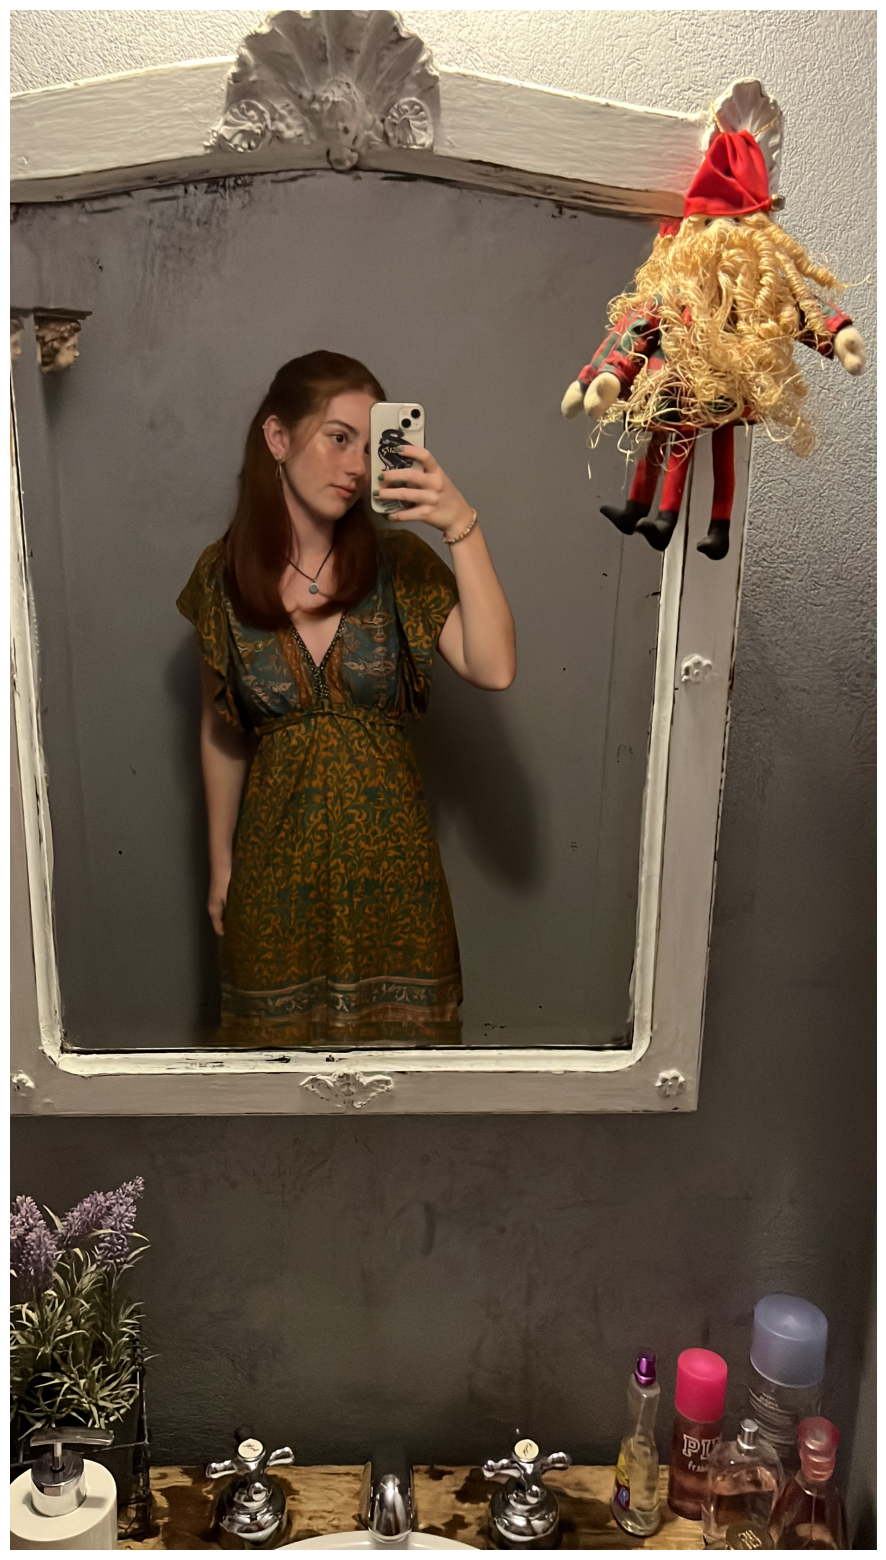

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [9]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

To generate masks, just run `generate` on an image.

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [10]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.92,
    crop_n_layers=0,
    min_mask_region_area=1000,  # Requires open-cv to run post-processing
)

In [11]:
masks = mask_generator.generate(image)

In [12]:
len(masks)

52

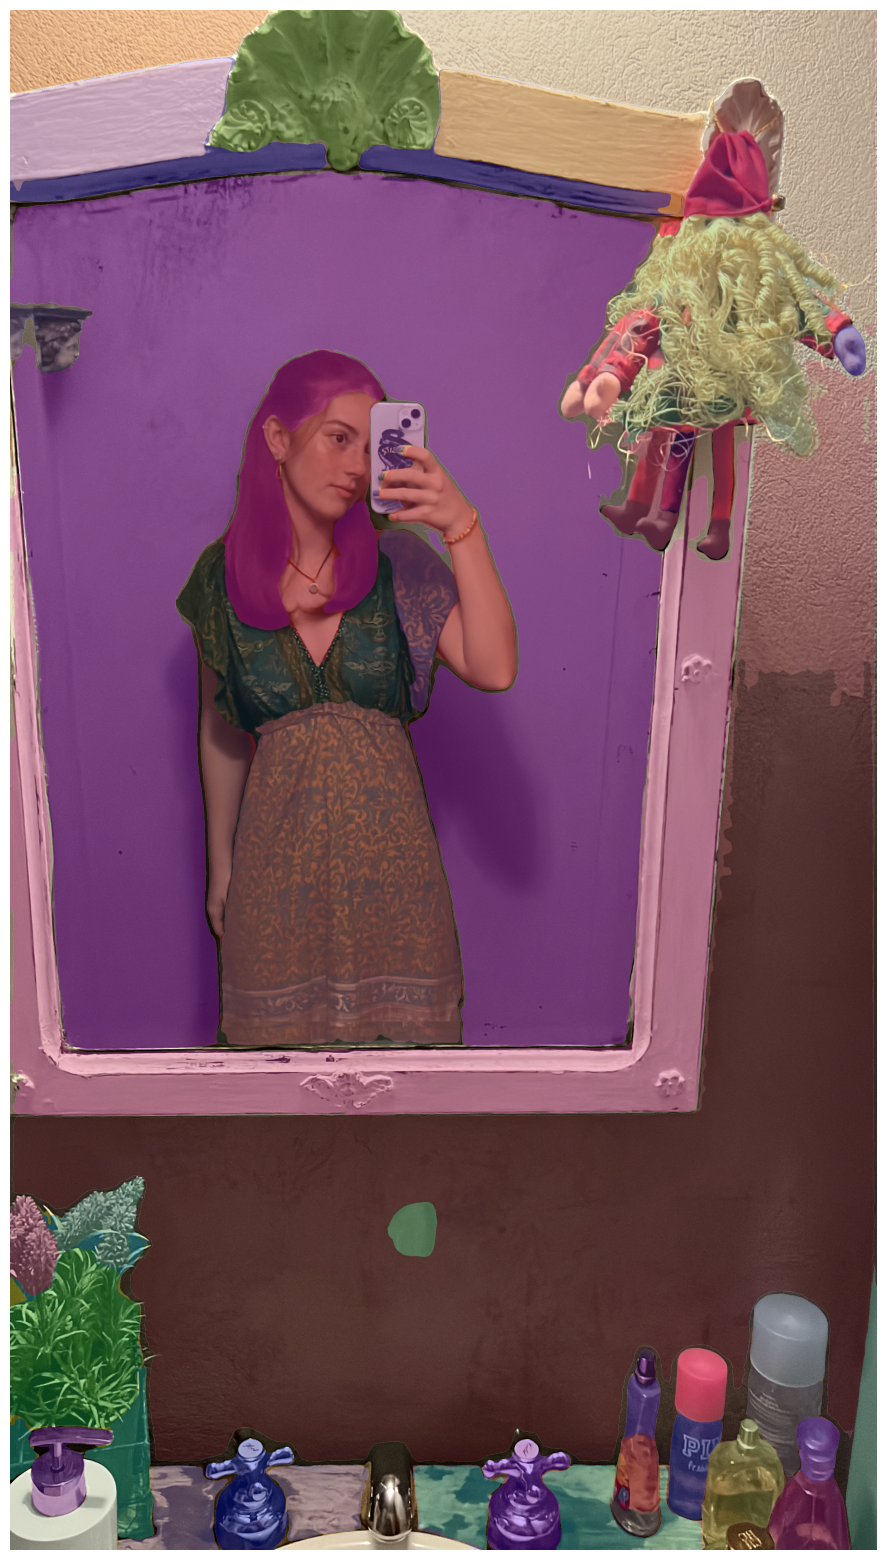

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Clip Image identifica la persona

In [14]:
import torch
import clip
from PIL import Image
import numpy as np

# Cargar modelo CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [15]:
# Definí tu prompt textual
text_prompt = "person with clothes and dress"  # Cambiá por "pants", "clothes", etc.
text_tokens = clip.tokenize([text_prompt]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)

# --- Acumular máscaras relevantes ---
mask_shape = masks[0]["segmentation"].shape
combined_mask = np.zeros(mask_shape, dtype=bool)
threshold = 0.267  # Ajustá este valor según tu caso

for i, mask in enumerate(masks):
    segmentation = mask["segmentation"]

    # Aplicar la máscara sobre la imagen original
    masked_image_np = image.copy()
    masked_image_np[~segmentation] = 0

    # Preprocesar para CLIP
    masked_pil = Image.fromarray(masked_image_np)
    processed = preprocess(masked_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(processed)
        similarity = torch.cosine_similarity(image_features, text_features).item()

    print(f"Máscara {i}: score CLIP = {similarity:.4f}")

    if similarity > threshold:
        combined_mask |= segmentation

# 'image' es tu array RGB original
image_pil = Image.fromarray(image).convert("RGBA")
image_np = np.array(image_pil)

# Usar la mejor máscara seleccionada por CLIP
mask = combined_mask # Esta es la máscara booleana que seleccionaste antes

# Asegurar que la imagen tenga canal alfa
if image_np.shape[2] == 3:
    image_np = np.concatenate([image_np, 255 * np.ones((*image_np.shape[:2], 1), dtype=np.uint8)], axis=2)

# Aplicar la máscara: lo que NO está en la máscara se vuelve transparente
image_np[~mask] = [0, 0, 0, 0]

# --- CROP automático ---
# Encontrar los límites del área con máscara (bounding box)
ys, xs = np.where(mask)
if ys.size > 0 and xs.size > 0:
    top, bottom = ys.min(), ys.max()
    left, right = xs.min(), xs.max()

    # Recortar la imagen y guardar
    cropped_image_np = image_np[top:bottom+1, left:right+1]
    cropped_image = Image.fromarray(cropped_image_np)
    cropped_image.save("images/selfie2_noBG.png")
    cropped_image.show()
else:
    print("⚠️ La máscara está vacía. No se puede hacer crop.")



Máscara 0: score CLIP = 0.2456
Máscara 1: score CLIP = 0.2456
Máscara 2: score CLIP = 0.2456
Máscara 3: score CLIP = 0.2697
Máscara 4: score CLIP = 0.2456
Máscara 5: score CLIP = 0.2456
Máscara 6: score CLIP = 0.2456
Máscara 7: score CLIP = 0.2456
Máscara 8: score CLIP = 0.2456
Máscara 9: score CLIP = 0.2456
Máscara 10: score CLIP = 0.2241
Máscara 11: score CLIP = 0.2456
Máscara 12: score CLIP = 0.2456
Máscara 13: score CLIP = 0.2456
Máscara 14: score CLIP = 0.2456
Máscara 15: score CLIP = 0.2456
Máscara 16: score CLIP = 0.2456
Máscara 17: score CLIP = 0.2456
Máscara 18: score CLIP = 0.2456
Máscara 19: score CLIP = 0.2456
Máscara 20: score CLIP = 0.2184
Máscara 21: score CLIP = 0.2248
Máscara 22: score CLIP = 0.2189
Máscara 23: score CLIP = 0.2456
Máscara 24: score CLIP = 0.2212
Máscara 25: score CLIP = 0.2218
Máscara 26: score CLIP = 0.2146
Máscara 27: score CLIP = 0.2548
Máscara 28: score CLIP = 0.2456
Máscara 29: score CLIP = 0.2456
Máscara 30: score CLIP = 0.2168
Máscara 31: score 

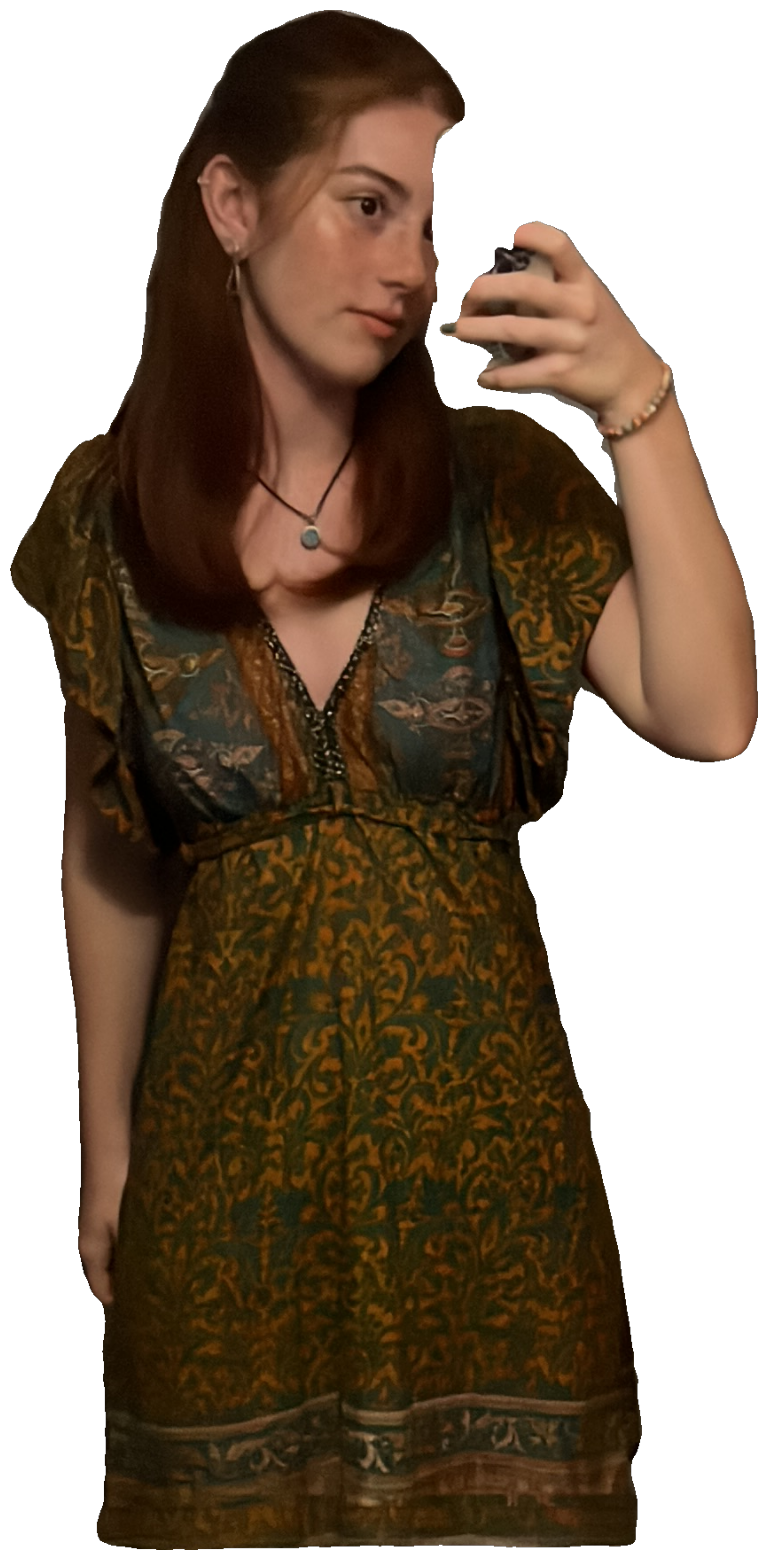

In [16]:
#Mostrar imagen con fondo eliminado
output_image = Image.open("images/selfie2_noBG.png")
plt.figure(figsize=(20,20))
plt.imshow(output_image)
plt.axis('off')
plt.show()

## Ahora SAM para los prendas

In [17]:
image2 = cv2.imread('images/selfie2_noBG.png')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

In [18]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    pred_iou_thresh=0.90,
    stability_score_thresh=0.95,
    crop_n_layers=0,
    min_mask_region_area=1000,  # Requires open-cv to run post-processing
)

In [19]:
masks2 = mask_generator_2.generate(image2)

In [20]:
len(masks2)

14

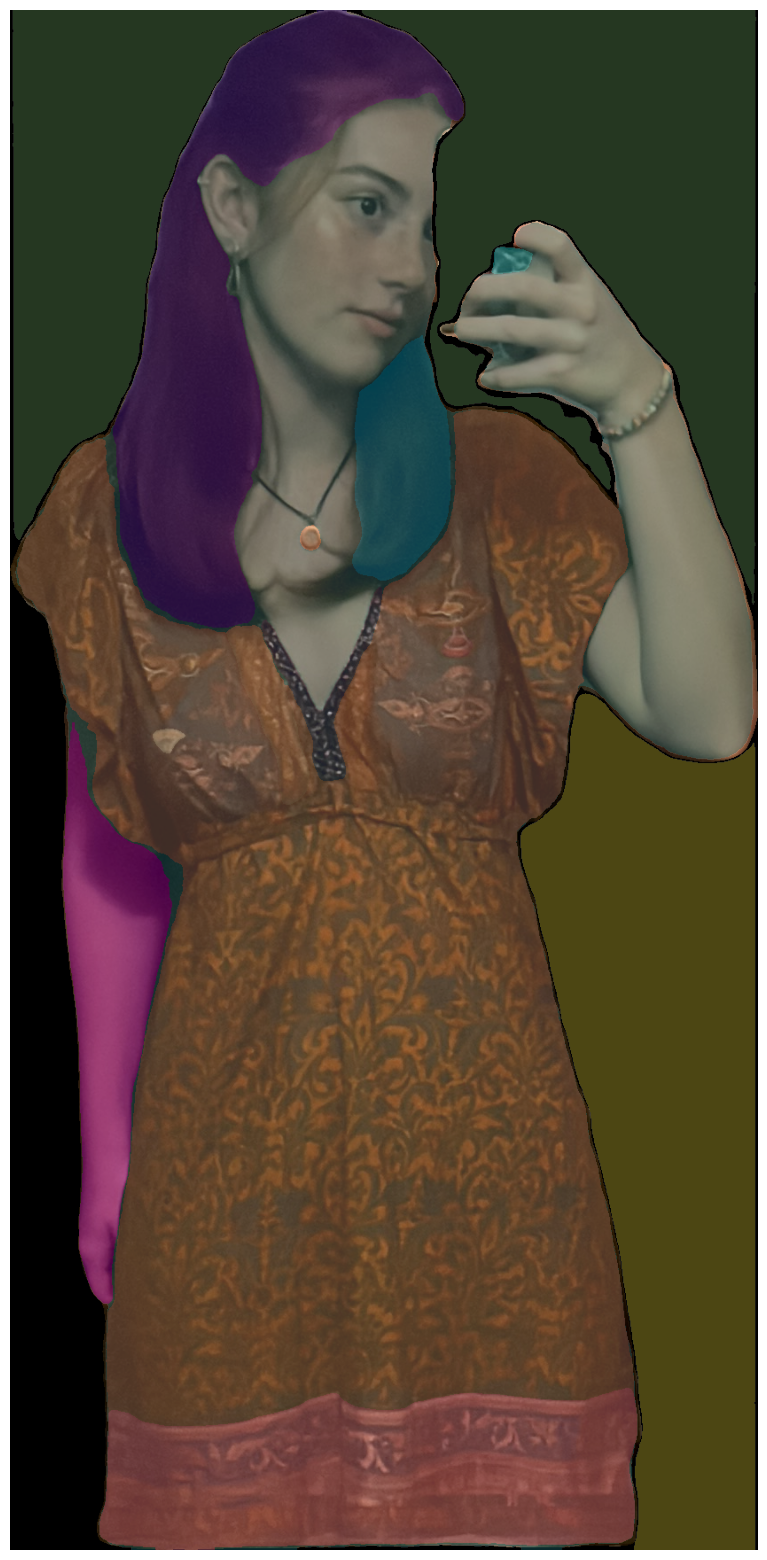

In [21]:
plt.figure(figsize=(20,20))
plt.imshow(image2)
show_anns(masks2)
plt.axis('off')
plt.show()

## Clip

In [22]:
import torch
import clip
from PIL import Image
import numpy as np

# Cargar modelo CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [25]:
# Definí tu prompt textual
text_prompt = "only dress"  # Si se pone only y prenda funciona
text_tokens = clip.tokenize([text_prompt]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)

# Evaluar cada máscara
best_score = -1
best_mask = None
best_crop = None

for i, mask in enumerate(masks2):
    segmentation = mask["segmentation"]  # Boolean numpy array

    # Aplicar máscara sobre la imagen original
    image_np = np.array(image2)
    masked_image_np = image_np.copy()
    masked_image_np[~segmentation] = 0  # Poner en negro lo que no está en la máscara

    # Convertir a PIL, procesar y pasar por CLIP
    masked_pil = Image.fromarray(masked_image_np)
    processed = preprocess(masked_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(processed)
        similarity = torch.cosine_similarity(image_features, text_features).item()

    print(f"Máscara {i}: score CLIP = {similarity:.4f}")
    
    if similarity > best_score:
        best_score = similarity
        best_mask = segmentation
        best_crop = masked_pil


Máscara 0: score CLIP = 0.2199
Máscara 1: score CLIP = 0.2447
Máscara 2: score CLIP = 0.2226
Máscara 3: score CLIP = 0.2176
Máscara 4: score CLIP = 0.2260
Máscara 5: score CLIP = 0.2163
Máscara 6: score CLIP = 0.2198
Máscara 7: score CLIP = 0.2589
Máscara 8: score CLIP = 0.2732
Máscara 9: score CLIP = 0.2198
Máscara 10: score CLIP = 0.2198
Máscara 11: score CLIP = 0.2012
Máscara 12: score CLIP = 0.2079
Máscara 13: score CLIP = 0.2171


In [26]:
print(f"Seleccionada la máscara con mejor match: score {best_score:.4f}")
best_crop.save("images/dress_crop.png")
best_crop.show()

Seleccionada la máscara con mejor match: score 0.2732


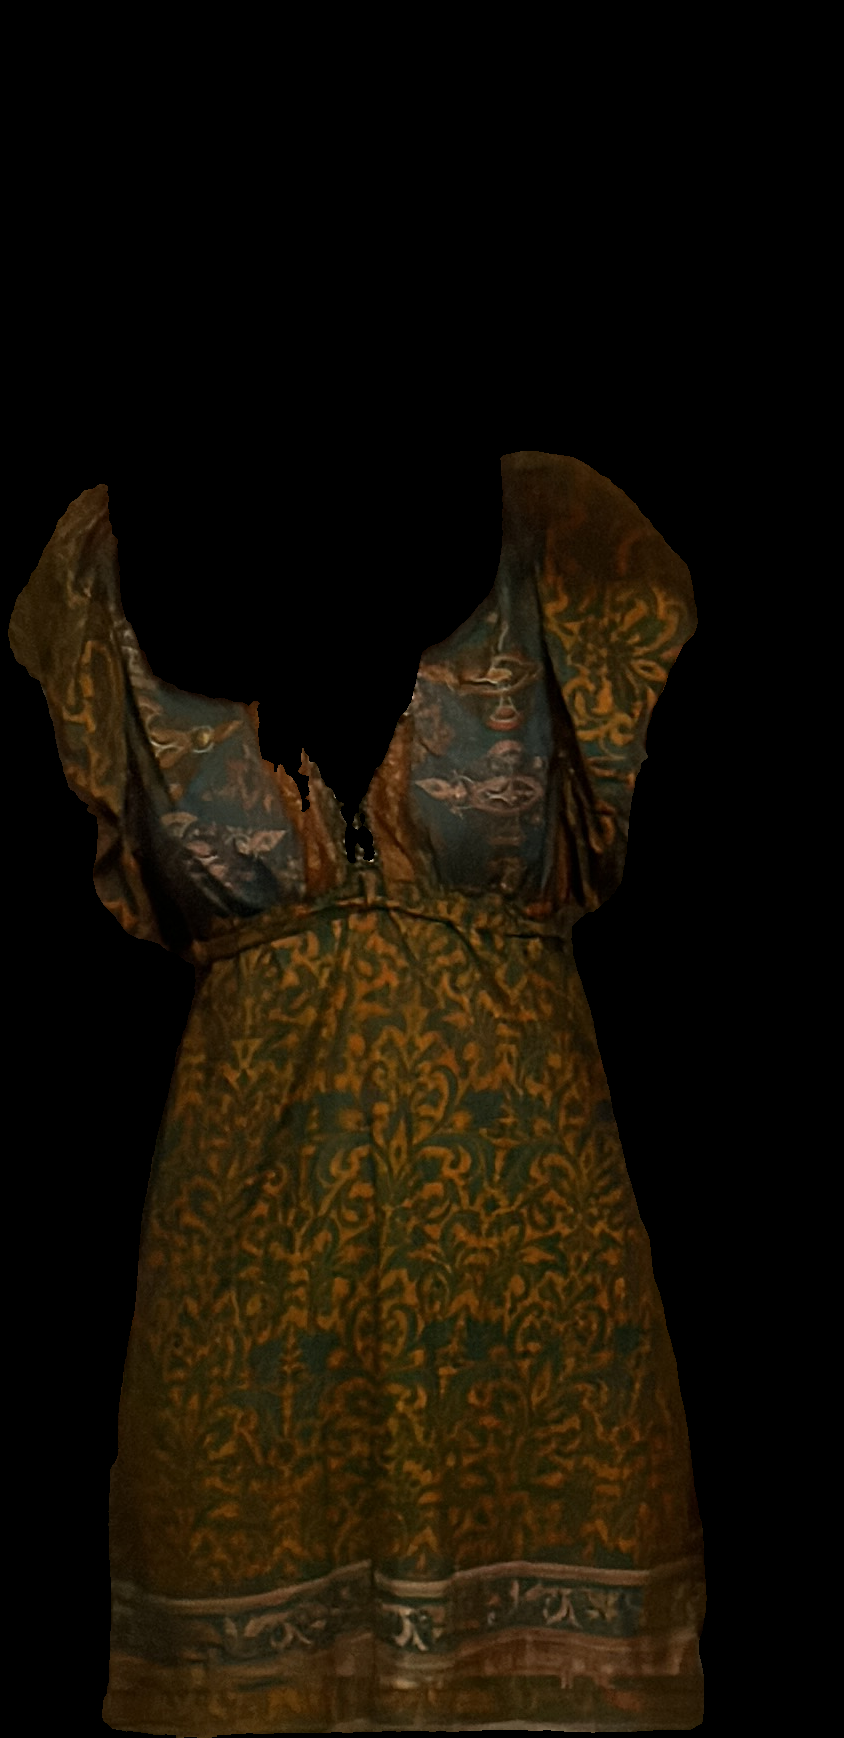

In [27]:
#Visualizo crops
img = Image.open("images/dress_crop.png")
display(img)

### Extraemos la metadata de la prenda

Cantidad de máscaras generadas: 3


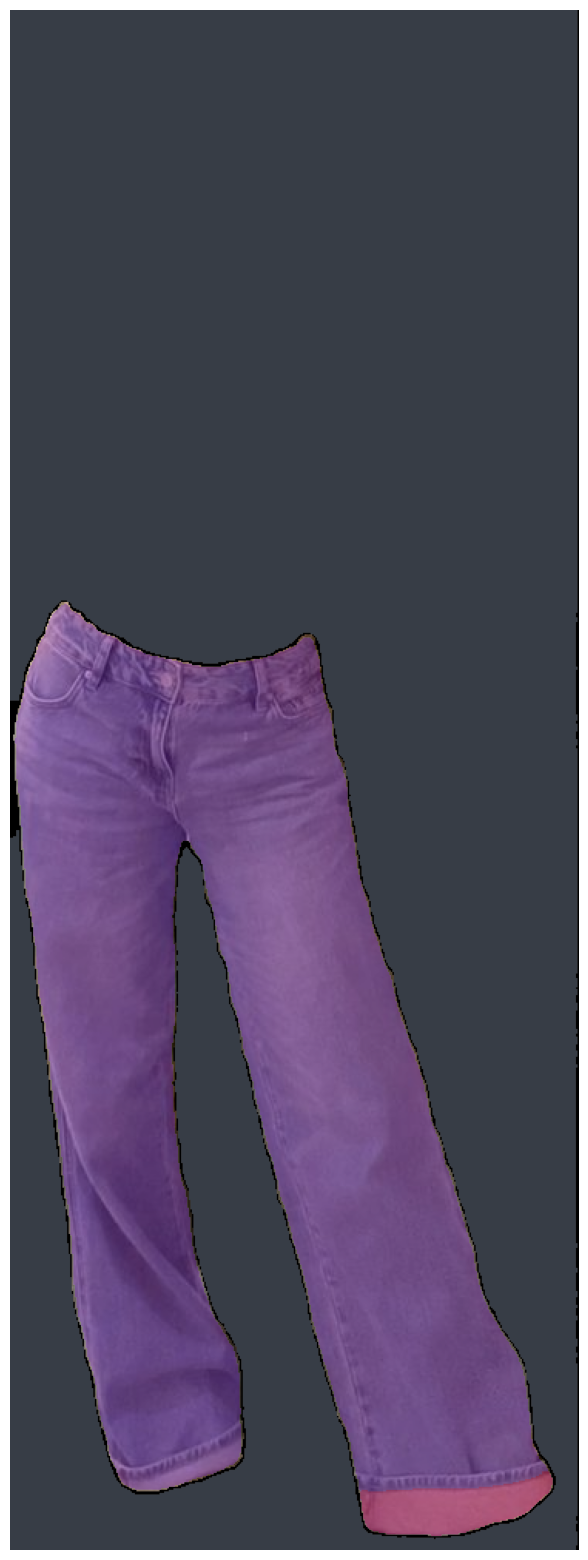

In [106]:
# Primero la pasamos por SAM otra vez

image3 = cv2.imread('images/pants_crop.png')
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)

mask_generator_3 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    pred_iou_thresh=0.90,
    stability_score_thresh=0.95,
    crop_n_layers=0,
    min_mask_region_area=1000,  # Requires open-cv to run post-processing
)

masks3 = mask_generator_3.generate(image3)

print(f"Cantidad de máscaras generadas: {len(masks3)}")

plt.figure(figsize=(20,20))
plt.imshow(image3)
show_anns(masks3)
plt.axis('off')
plt.show()

In [107]:
import torch
import clip
from PIL import Image
import numpy as np
import os

# --- CONFIGURACIÓN ---
threshold = 0.265  # Ajustá esto según lo estricto que quieras ser
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
all_descriptions = []

# Cargar imagen
image_path = "images/pants_crop.png"
image_pil = Image.open(image_path)
image_np = np.array(image_pil)

# Lista de descripciones
descriptions = [
    # Textura
    "knitted", "print", "estampado", "stripped", "leather", "plain", "textura rugosa", "shiny material", "opaque", "flowers",
    # Estilo
    "casual", "urban", "vintage", "modern", "oversize", "slim fit", "sporty", "sports clothes", "loose", "baggy", "tight", "summer", "winter",
    # Marca
    "like Zara", "Adidas style", "look Nike", "like H&M", "luxury", "remium",
    # Material
    "cotton", "pollyester", "denim", "silk", "leather", "wool", "linen", "shiny", "mezclilla", "jean",
    # Colores
    "red", "blue", "green", "yellow", "black", "white", "gray", "brown", "purple", "orange", "pink", "gold", "silver", "beige", "turquoise", "cyan", "magenta", "light blue"
]

# Codificar textos
text_tokens = clip.tokenize(descriptions).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Lista para guardar resultados
resultados_por_mascara = []

# Evaluar cada máscara
for idx, mask in enumerate(masks3):
    segmentation = mask["segmentation"]  # bool numpy array
    masked_np = image_np.copy()
    masked_np[~segmentation] = 0  # Fondo negro

    masked_pil = Image.fromarray(masked_np)
    processed = preprocess(masked_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(processed)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = (image_features @ text_features.T).squeeze(0)

    # Guardar descripciones relevantes
    descripciones_relevantes = []
    for i, score in enumerate(similarity):
        if score.item() > threshold:
            descripciones_relevantes.append((descriptions[i], score.item()))

    resultados_por_mascara.append({
        "mask_index": idx,
        "descripciones": descripciones_relevantes
    })

# Imprimir resultados
for resultado in resultados_por_mascara:
    print(f"\nMáscara {resultado['mask_index']}:")
    for desc, score in resultado["descripciones"]:
        print(f"- {desc} ({score:.2f})")
        all_descriptions.append(desc)

        similarity = (image_features @ text_features.T).squeeze(0)

# Eliminar duplicados
descriptions = list(set(all_descriptions))

# --- MOSTRAR RESULTADO ---
print(f"\nDescripciones con similitud > {threshold}:\n")
for desc in descriptions:
    print(f"- {desc}")



Máscara 0:
- slim fit (0.27)
- denim (0.27)
- jean (0.27)

Máscara 1:

Máscara 2:

Descripciones con similitud > 0.265:

- slim fit
- denim
- jean


In [108]:
from PIL import Image
import numpy as np
import cv2
from sklearn.cluster import KMeans

def get_dominant_color_filtered(image_path, mask, num_colors=3, saturation_boost=1.5, min_brightness=50):
    image = Image.open(image_path).convert('RGBA')
    image_np = np.array(image)

    if mask.shape != image_np.shape[:2]:
        raise ValueError("La máscara no coincide con la imagen.")

    mask = mask.astype(bool)

    image_bgr = cv2.cvtColor(image_np[..., :3], cv2.COLOR_RGB2BGR)
    image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(image_hsv)

    s = s.astype(np.float32)
    s[mask] = np.clip(s[mask] * saturation_boost, 0, 255)
    s = s.astype(np.uint8)

    hsv_boosted = cv2.merge([h, s, v])
    bgr_boosted = cv2.cvtColor(hsv_boosted, cv2.COLOR_HSV2BGR)
    rgb_boosted = cv2.cvtColor(bgr_boosted, cv2.COLOR_BGR2RGB)

    # Solo píxeles dentro de máscara y con brillo (valor V) >= min_brightness
    pixels_mask = mask & (v >= min_brightness)

    pixels = rgb_boosted[pixels_mask]

    if len(pixels) == 0:
        return []

    n_colors = min(num_colors, len(pixels))
    kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(pixels)
    centers = kmeans.cluster_centers_.astype(int)

    hex_colors = ['#%02x%02x%02x' % tuple(center) for center in centers]
    return hex_colors

colores = []
for i, mask_data in enumerate(masks3):
    hex_colors = get_dominant_color_filtered(
        image_path="images/pants_crop.png",
        mask=mask_data["segmentation"],
        saturation_boost=2.0,
        min_brightness=50
    )
    print(f"Máscara {i} - Colores principales:")
    for c in hex_colors:
        print(f"  {c}")
        colores.append(c)

Máscara 0 - Colores principales:
  #5a5242
  #776a58
  #483c26
Máscara 1 - Colores principales:
  #907154
  #715335
  #906540
Máscara 2 - Colores principales:


In [109]:
from PIL import Image, ImageDraw, ImageFont

def show_color_palette(hex_colors, block_size=50, horizontal=True):
    """
    Visualiza una lista de colores hexadecimales como bloques de color.
    """
    num_colors = len(hex_colors)
    width = block_size * num_colors if horizontal else block_size
    height = block_size if horizontal else block_size * num_colors

    # Crear imagen en blanco
    palette = Image.new('RGB', (width, height), color=(255, 255, 255))
    draw = ImageDraw.Draw(palette)

    # Dibujar los bloques
    for i, hex_color in enumerate(hex_colors):
        if horizontal:
            x0, y0 = i * block_size, 0
            x1, y1 = (i + 1) * block_size, block_size
        else:
            x0, y0 = 0, i * block_size
            x1, y1 = block_size, (i + 1) * block_size

        draw.rectangle([x0, y0, x1, y1], fill=hex_color)

    palette.show()

show_color_palette(colores)


### Vamos a usar inpainting para completar la prenda

In [95]:
from PIL import Image, ImageChops

# Cargá la imagen original con huecos
img_with_holes = Image.open("images/dress_crop.png").convert("RGBA")

# Convertir canal alfa a máscara de huecos (zonas transparentes)
alpha = img_with_holes.split()[-1]
mask_holes = alpha.point(lambda p: 255 if p < 255 else 0).convert("L")
mask_holes.save("images/dress_holes.png")


In [ ]:
import openai
from PIL import Image
import io

openai.api_key = "sk-..."  # O mejor usar variables de entorno

# Imagen con huecos
image = Image.open("images/dress_crop.png").convert("RGBA").resize((1024, 1024))
# Máscara generada automáticamente
mask = Image.open("images/dress_holes.png").convert("L").resize((1024, 1024))

# Convertir a BytesIO
image_bytes = io.BytesIO()
mask_bytes = io.BytesIO()
image.save(image_bytes, format="PNG")
mask.save(mask_bytes, format="PNG")
image_bytes.seek(0)
mask_bytes.seek(0)

# Prompt para guiar la reconstrucción - la idea es que sea "a complete..." + nombre de prenda + prompts idnetificados
prompt = "a complete dress" + ", ".join(descriptions)

# Inpainting
response = openai.images.edit(
    prompt=prompt,
    n=1,
    size="1024x1024",
    image=("image.png", image_bytes, "image/png"),
    mask=("mask.png", mask_bytes, "image/png"),
)

# Resultado
generated_url = response["data"][0]["url"]
print("Imagen generada:", generated_url)


BadRequestError: Error code: 400 - {'error': {'message': 'Billing hard limit has been reached', 'type': 'image_generation_user_error', 'param': None, 'code': 'billing_hard_limit_reached'}}

Seleccionada la máscara con mejor match: score 0.2280


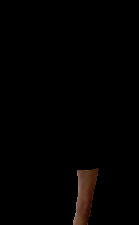

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# Cargar pipeline inpainting
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
).to(device)

# Cargar imagen de entrada y máscara
image = Image.open("images/pants_crop_with_holes.png").convert("RGB")
mask_image = Image.open("images/mask_holes.png").convert("L")  # blanco = rellenar

# Prompt para guiar la restauración
prompt = "a complete cotton red t-shirt"

# Inpainting
output = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]

# Guardar resultado
output.save("images/prenda_reconstruida.png")
